In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
#from scipy.io import netcdf
import xarray as xr
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
import re
import warnings
warnings.filterwarnings("ignore")


In [2]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        new_columns.append(pd.to_datetime(col).date())
    return new_columns

In [3]:
# import daily_temp to extract corrsponding dates
daily_temp = pd.read_csv("dataset/temperature/daily_temp.csv").set_index("proj_id")
daily_temp.columns= convert_col_to_date(daily_temp.columns)
print(daily_temp.shape)
daily_temp.head()

(12382, 6544)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,46,59,35,48,62,63,65,49,39,15
BB_25470024,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,46,59,35,48,62,63,65,49,39,15
BB_25480025,17,-6,-27,-67,-63,-80,-74,-52,-19,18,...,44,58,33,49,60,61,64,48,42,19
BB_25480026,14,-8,-28,-65,-65,-81,-77,-56,-20,16,...,46,59,36,49,62,63,65,49,38,15
BB_25481088,17,-6,-26,-66,-62,-80,-74,-52,-19,18,...,44,59,33,49,60,62,64,48,42,19


In [4]:
# dates in which the prec should be extracted
dates = daily_temp.columns
years =[i for i in range(1995,2013)]
print(f"number of total dates {len(dates)}")
# split the dates per year, to save one nc file for each year, to avoid size problem
dates_per_year ={}
for year in years:
    dates_per_year[str(year)]=[day for day in dates if day.year==year]


number of total dates 6544


In [5]:
# compute the real long/lat for each point of the grid of an ascii file
# x:long , y:lat
xdelta = 1.0 * (1./60.)
ydelta = 1.0 * (1./120.)

# compute the real long/lat for each point of the grid
long =[( 6. - 10.*xdelta) + (pt - 1)*xdelta for pt in range(0,611)]
lat =[(55. + 10.*ydelta) - (pt - 1)*ydelta for pt in range(0,971)]

In [ ]:
# create nc file for each year and store the prec values
#dims are the long/lat and the dates, the layers(variables) prec values on each day(assci file)
print(datetime.now())
print("##################")
for year in years:
    t1=datetime.now()
    print(t1)

    
    root_grp = Dataset(f'dataset/regnie_dwd/nc/{year}.nc', 'w', format='NETCDF4')
    root_grp.description = 'dims are the long/lat and the dates,(variables) prec values on each day'

    # create dimensions
    root_grp.createDimension('time', None)
    root_grp.createDimension('x', 611)
    root_grp.createDimension('y', 971)

    # create variables
    time = root_grp.createVariable('time', 'f8', ('time',))
    x = root_grp.createVariable('x', 'f4', ('x',))
    y = root_grp.createVariable('y', 'f4', ('y',))
    #each field represents a layer of prec values on a day
    field = root_grp.createVariable('field', 'f8', ('time', 'x', 'y',))

    #upload data on th dims
    x[:] = long
    y[:] = lat
    print(f"nc {year} created")
    days= dates_per_year[str(year)]
    for i, day in enumerate(days):
        
        file_name = "ra"+"".join(str(day).split("-"))[2:]

        # open an ascii file
        f = open(f'dataset/regnie_dwd/data/unzip/{file_name}', 'r')
        # extract the lines
        lines=[]
        for line in f:
            lines.append(repr(line))

        # the grid is 611x971 (west/east - northsouth)(long-lat)(x,y)
        # intialize the grid
        grid = np.zeros((971,611))
        #extract the prec values and add them to the grid
        for l, line in enumerate(lines[:-1]):# last line ignored because it is related to the time-date
            int_line = [int(l) if int(l)<999 else 999 for l in  re.sub(' +','-',line)[2:-3].replace("--","-").split("-")]
            grid[l,:(len(int_line))]= int_line

        grid =pd.DataFrame(grid)
        # add the grid as alyaer in the nc
        time[i]=i
        field[i,:,:]=grid.T
    print(f'{i} days of {year} are done')
    root_grp.close()
    t2=datetime.now()
    print(t2)
    print(t2-t1)
    print(" ")

print("##############")
print(datetime.now())

#### time for creating all nc files: 1:21:39 h

In [6]:
# import the location of bgr_stations
bgr_loc = pd.read_csv("dataset/meta_data/bgr_location.csv").set_index("proj_id")
bgr_loc = bgr_loc[bgr_loc.columns[:2]]
print(bgr_loc.shape)
bgr_loc.head()

(13492, 2)


,bgr_long,bgr_lat
proj_id,,
BB_25470023,13.643609,53.416804
BB_25470024,13.643653,53.416793
BB_25480025,13.826532,53.452024
BB_25480026,13.677407,53.457078
BB_25481088,13.821475,53.475857


In [7]:
# intialize the daily_prec df
# 1995 computed in advance 
daily_prec=pd.read_csv("dataset/regnie_dwd/csv/daily_prec.csv").set_index("proj_id")
daily_prec

,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,1996-12-22,1996-12-23,1996-12-24,1996-12-25,1996-12-26,1996-12-27,1996-12-28,1996-12-29,1996-12-30,1996-12-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,7.0,0.0,0.0,21.0,0.0,0.0,0.0,12.0,0.0,0.0
BB_25470024,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,7.0,0.0,0.0,21.0,0.0,0.0,0.0,12.0,0.0,0.0
BB_25480025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20.0,3.0,0.0,0.0,17.0,0.0,0.0
BB_25480026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,31.0,0.0,0.0,0.0,17.0,0.0,0.0
BB_25481088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,28.0,2.0,0.0,0.0,25.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TH_5633900046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,1.0,0.0
TH_5633900056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,1.0,0.0
TH_5633900114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0


In [8]:
# compute prec at each bgr station


def compute_prec(row):
    # return an series of all prec at one bgr long/lat over time dim in the nc file (365/364 days)
    bgr = row["bgr_long"], row["bgr_lat"]
    prec_year_list.append(ds.field.sel(x=bgr[0], y=bgr[1] ,  method='nearest').values)


# open the nc file as dataset
t3 =datetime.now()
print(t3)
print("#############")
for year in years[1:]:
    
    t1 = datetime.now()
    print(t1)
    print(f"year: {year}")
    # open nc
    ds = xr.open_dataset(f'dataset/regnie_dwd/nc/{str(year)}.nc')
    prec_year_list =[]
    #extrac prec
    bgr_loc.apply(lambda row:compute_prec(row), axis=1)
    prec_year = pd.DataFrame(prec_year_list)
    prec_year.index = bgr_loc.index
    prec_year.columns = dates_per_year[str(year)]
    # join the new year to the previous df
    # save the daily_prec in an csv
    prec_year.to_csv(f"dataset/regnie_dwd/csv/{year}.csv")
    #daily_prec = pd.concat([daily_prec,prec_year], axis=1)
    
    t2 = datetime.now()
    print(t2)
    print(t2-t1)
    print(f"{year} added")

print("#############")
t4 =datetime.now()
print(t4)
print(f"total time: {t4-t3}")

2020-12-21 10:37:43.536276
#############
2020-12-21 10:37:43.536831
year: 1997
2020-12-21 11:02:56.496772
0:25:12.959941
1997 added
2020-12-21 11:02:56.496934
year: 1998
2020-12-21 11:31:40.461543
0:28:43.964609
1998 added
2020-12-21 11:31:40.461723
year: 1999
2020-12-21 12:00:15.343277
0:28:34.881554
1999 added
2020-12-21 12:00:15.343623
year: 2000
2020-12-21 12:27:22.500831
0:27:07.157208
2000 added
2020-12-21 12:27:22.501447
year: 2001
2020-12-21 12:55:33.652934
0:28:11.151487
2001 added
2020-12-21 12:55:33.653511
year: 2002
2020-12-21 13:22:38.114307
0:27:04.460796
2002 added
2020-12-21 13:22:38.114928
year: 2003
2020-12-21 13:48:13.243185
0:25:35.128257
2003 added
2020-12-21 13:48:13.243349
year: 2004
2020-12-21 14:15:48.419461
0:27:35.176112
2004 added
2020-12-21 14:15:48.419653
year: 2005
2020-12-21 14:41:26.623513
0:25:38.203860
2005 added
2020-12-21 14:41:26.623685
year: 2006
2020-12-21 15:06:32.140595
0:25:05.516910
2006 added
2020-12-21 15:06:32.141154
year: 2007
2020-12-21 

### time to compute all daily preec and save them in csv is 7:51:52 h

In [20]:
# merge all dfs in one daily_prec
daily_prec=pd.read_csv("dataset/regnie_dwd/csv/1995.csv").set_index("proj_id")
for year in years[1:]:
    df=pd.read_csv(f"dataset/regnie_dwd/csv/{year}.csv").set_index("proj_id")
    daily_prec = pd.concat([daily_prec,df],axis=1)
print(daily_prec.shape)
daily_prec.head()
# save the daily_prec df
#daily_prec.to_csv("dataset/regnie_dwd/csv/daily_prec.csv")

(13492, 6544)


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,0.0,1.0,6.0,8.0,5.0,21.0,0.0,17.0,108.0,6.0
BB_25470024,3.0,25.0,0.0,0.0,0.0,0.0,0.0,14.0,64.0,18.0,...,0.0,1.0,6.0,8.0,5.0,21.0,0.0,17.0,108.0,6.0
BB_25480025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.0,6.0,4.0,22.0,0.0,5.0,118.0,2.0
BB_25480026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,7.0,5.0,22.0,0.0,22.0,116.0,6.0
BB_25481088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.0,6.0,4.0,22.0,0.0,12.0,122.0,3.0


In [33]:
#bgr_serial = 1246 #freq 1
#bgr_serial =  #freq 
bgr_serial = 13000 #freq 7
#bgr_serial = 2461 #freq 7
#bgr_serial = 4689 #freq 14
#bgr_serial = 8888 #freq 30
#f =ave_temp.iloc[bgr_serial][-1] 
#ts_index = grouped_t_s.iloc[bgr_serial].dropna().index
#ts_index = ts_index[ts_index < ave_temp.iloc[bgr_serial].index[-2]]

<AxesSubplot:>

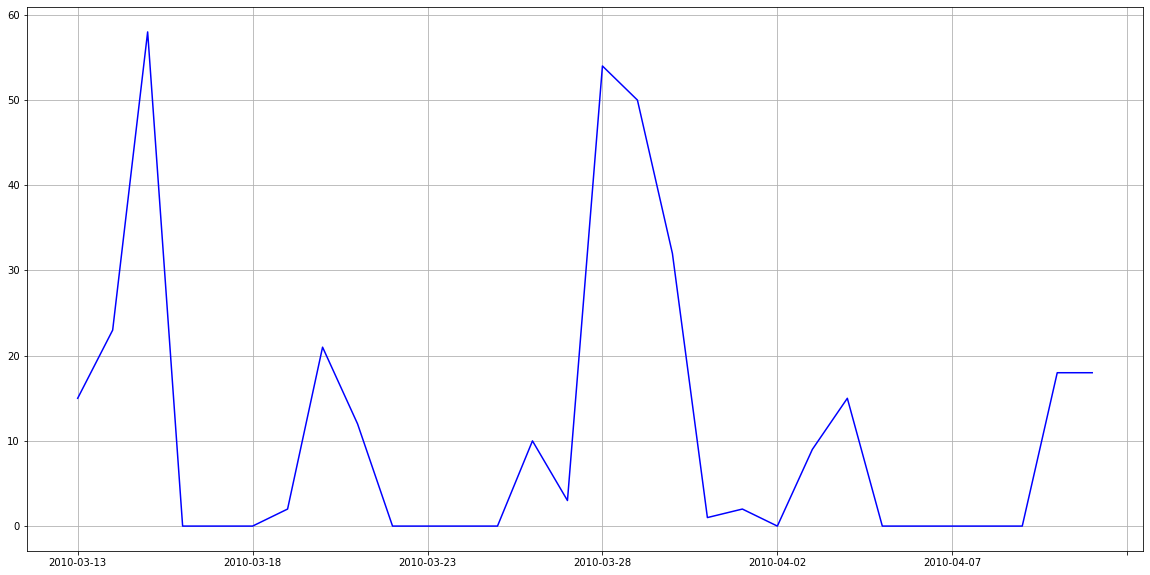

In [37]:
plt.figure(figsize=(20,10))
#daily_prec.iloc[bgr_serial].dropna()[ts_index][:100].plot(color='blue',grid=True)

daily_prec.iloc[bgr_serial][5550:5580].plot(color='blue',grid=True)
#daily_temp.iloc[bgr_serial].dropna()[ts_index][:100].plot(color='red',grid=True, secondary_y=True)
#ave_temp.loc["BB_25481088"].dropna()[5000:5200].plot(color='red',grid=True, secondary_y=True)
#plt.title(f"daily_prec (red) vs cum_prec (blue) at a bgr station, freq={f}")

#### extract all the dates in t s and put them in a list, then build nc file for all these days as layers, the we  slice over all days(time) at the same loc to create a t s, and store it in dict with its bgr_id

## apply the func on a df for all bgr stations